# PyTorch-ification

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

torch.set_printoptions(linewidth=140)

In [2]:
words = open("names.txt", "r").read().splitlines()
print(f"First few words: {words[:5]}\nNumber of words: {len(words)}")

First few words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Number of words: 32033


In [3]:
chars = ["."] + sorted(set("".join(words)))
char_to_ix = {s: i for i, s in enumerate(chars)}
ix_to_char = {i: s for s, i in char_to_ix.items()}
vocab_size = len(chars)

In [4]:
block_size = 3

In [5]:
def build_dataset(words, block_size=3, verbose=False):
  X, Y = [], []
  for word in words:
    padded_word = ["."] * block_size + list(word) + ["."]
    for i in range(len(padded_word)-block_size):
      context = [char_to_ix[char] for char in padded_word[i:i+block_size]]
      target = char_to_ix[padded_word[i+block_size]]
      X.append(context)
      Y.append(target)
  X, Y = torch.tensor(X), torch.tensor(Y)
  if verbose:
    print(f"{X.shape}\t{Y.shape}")
  return X, Y

In [6]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [7]:
X_train, Y_train = build_dataset(words[:n1], block_size=block_size, verbose=True)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size=block_size, verbose=True)
X_test, Y_test = build_dataset(words[n2:], block_size=block_size, verbose=True)

torch.Size([182625, 3])	torch.Size([182625])
torch.Size([22655, 3])	torch.Size([22655])
torch.Size([22866, 3])	torch.Size([22866])


In [8]:
for x, y in zip(X_train[:5], Y_train[:5]):
  print(''.join(ix_to_char[int(ix.item())] for ix in x), '-->', ix_to_char[int(y.item())])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n


In [9]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weights = torch.randn((num_embeddings, embedding_dim))
  
  def __call__(self, IX):
    self.out = self.weights[IX]
    return self.out
  
  def parameters(self):
    return [self.weights]


class Flatten:
  
  def __init__(self):
    pass
  
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1) # maintain the batch dimension
    return self.out
  
  def parameters(self):
    return []


# Holds a list of layers. See PyTorch containers.
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
    
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [10]:
torch.manual_seed(42);

In [11]:
embedding_dim = 10
hidden_layer_size = 200

model = Sequential([
  Embedding(vocab_size, embedding_dim), Flatten(),
  Linear(embedding_dim*block_size, hidden_layer_size, bias=False), BatchNorm1d(hidden_layer_size), Tanh(),
  Linear(hidden_layer_size, vocab_size, bias=True)
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # make the last layer less confident # type: ignore

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


In [12]:
max_steps = 200_000
batch_size = 32
lossi = []

for step in range(max_steps):
  
  # minibatch construct
  ixs = torch.randint(0, X_train.shape[0], (batch_size,))
  Xb, Yb = X_train[ixs], Y_train[ixs]
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if step < 150_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad # type: ignore
  
  # track stats
  if step % 10_000 == 0:
    print(f"{step}/{max_steps}\t{loss.item():.4f}")
  lossi.append(loss.item())

0/200000	3.2966
10000/200000	2.2322
20000/200000	2.4111
30000/200000	2.1004
40000/200000	2.3157
50000/200000	2.2104
60000/200000	1.9653
70000/200000	1.9767
80000/200000	2.6738
90000/200000	2.0837
100000/200000	2.2730
110000/200000	1.7491
120000/200000	2.2891


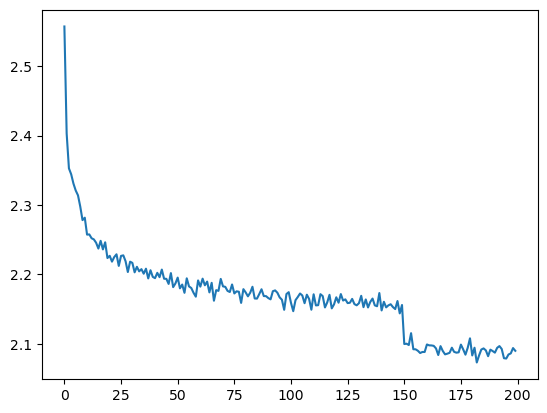

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1));

In [ ]:
# put all layers into eval mode (this only matters for batchnorm)
for layer in model.layers:
  layer.training = False

In [ ]:
@torch.no_grad() # disables gradient tracking
def evaluate(X, Y): 
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    return loss.item()

In [ ]:
print(f"Training split loss: {evaluate(X_train, Y_train):.4f}")
print(f"Development split loss: {evaluate(X_dev, Y_dev):.4f}")

Training split loss: 2.0583
Development split loss: 2.1065


In [ ]:
print(f"Test split loss: {evaluate(X_test, Y_test):.4f}")

Test split loss: 2.1046


In [ ]:
with torch.no_grad():
    g = torch.Generator().manual_seed(5)
    for _ in range(20):
        context = ["."] * block_size
        out = []
        while True:
            x = torch.tensor([[char_to_ix[char] for char in context]])
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            if ix==0:
                break
            char = ix_to_char[ix] # type: ignore
            context = context[1:] + [char]
            out.append(char)
        print("".join(out), end="\n")

karyi
zipper
esma
gaizolewin
brayden
fina
noen
mice
alaidan
huxis
aryseesabrie
ter
jalaniyah
odecharle
aayzen
rlina
novaya
yoorgi
zayvinitayvespier
halia
